In [9]:
import sys
sys.path += ["../src"]

from opinion_dynamics_models_estimation import simulate_BC
import pandas as pd
import opinion_dynamics_models_estimation as oe


from MSM_calibrator import calibrate_params_ABM
from MSM_simulators import BC_simulator, BC_simulator_positive_observations, BC_simulator_X_evidences, BC_simulator_X_evidences_backfire
import json

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
import repeat_function
from importlib import reload
from scipy.special import expit as sigmoid
from time import time

In [11]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [12]:
hyperparams_simple_BC = json.load(open("../data/hyperparams_simple_bc.json", 'r'))
hyperparams_obs_pos_BC = json.load(open("../data/hyperparams_obs_pos_bc.json", 'r'))
hyperparams_evidence_BC = json.load(open("../data/hyperparams_evidence_bc.json", 'r'))
hyperparams_backfire_BC = json.load(open("../data/hyperparams_backfire_bc.json", 'r'))

In [5]:
def complete_comparison_simple_BC(N, T, edge_per_t, evidences_per_t = 1, rho = 16,
                                  calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    #epsilon, mu = np.random.random(2) / 2
    mu = 0.1
    epsilon = np.random.random() / 2
    
    X, edges, _ = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    simulator = BC_simulator(X[0], edges, N, mu, epsilon, rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, calibration_batches = calibration_batches, ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, _, (epsilon, mu, rho), **hyperparams_simple_BC)
    
    return {"real_epsilon": epsilon, 
            "mu": mu, 
            "rho": rho, 
            "epsilon_msm": calibration_df["epsilon"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches, 
            "abs_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon),
            "rel_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon) / epsilon,
            "ensemble_size": ensemble_size,
            "epsilon_pgabm": pgabm_estimation["epsilon_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm": pgabm_estimation["distance_epsilon"],
            "rel_error_pgabm": pgabm_estimation["distance_epsilon"] / epsilon,
            "num_epochs": pgabm_estimation["num_epochs"]
           }


def complete_comparison_BC_observed_positive(N, T, edge_per_t, evidences_per_t = 1, rho = 16, calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    #epsilon, mu = np.random.random(2) / 2
    mu = 0.1
    epsilon = np.random.random() / 2
    X, edges,_ = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    simulator = BC_simulator_positive_observations(X[0], edges, N, mu, epsilon, rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, calibration_batches = calibration_batches, ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, _, (epsilon, mu, rho), **hyperparams_obs_pos_BC)
    
    return {"real_epsilon": epsilon, 
            "mu": mu, 
            "rho": rho, 
            "epsilon_msm": calibration_df["epsilon"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches, 
            "abs_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon),
            "rel_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon) / epsilon,
            "ensemble_size": ensemble_size,
            "epsilon_pgabm": pgabm_estimation["epsilon_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm": pgabm_estimation["distance_epsilon"],
            "rel_error_pgabm": pgabm_estimation["distance_epsilon"] / epsilon,
            "num_epochs": pgabm_estimation["num_epochs"]
           }


def complete_comparison_BC_with_evidences(N, T, edge_per_t, evidences_per_t, rho = 16, calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    #epsilon, mu = np.random.random(2) / 2
    mu = 0.1
    epsilon = np.random.random() / 2
    
    X, edges, evidences = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    simulator = BC_simulator_X_evidences(N, edges, evidences, mu, epsilon, rho = rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, calibration_batches = calibration_batches, ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, evidences, (epsilon, mu, rho), **hyperparams_evidence_BC)
    
    return {"real_epsilon": epsilon, 
            "mu": mu, 
            "rho": rho, 
            "epsilon_msm": calibration_df["epsilon"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches, 
            "abs_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon),
            "rel_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon) / epsilon,
            "ensemble_size": ensemble_size,
            "epsilon_pgabm": pgabm_estimation["epsilon_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm": pgabm_estimation["distance_epsilon"],
            "rel_error_pgabm": pgabm_estimation["distance_epsilon"] / epsilon,
            "X0_r2": pgabm_estimation["X0_r2"],
            "X0_mae": pgabm_estimation["X0_mae"],
            "X0_mse": pgabm_estimation["X0_mse"],
            "num_epochs": pgabm_estimation["num_epochs"]
           }

def complete_comparison_BC_backfire(N, T, edge_per_t, evidences_per_t, rho = 16, calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    epsilon_plus = np.random.random() / 2
    epsilon_minus = 0.5 + (np.random.random() / 2)
    #mu_plus = mu_minus = np.random.random() / 2
    mu_plus = mu_minus = 0.1
    
    X, edges, evidences = simulate_BC(N, T, edge_per_t, evidences_per_t, 
                                      (epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho), model = "backfire")
    simulator = BC_simulator_X_evidences_backfire(N, edges, evidences, mu_plus, mu_minus, 
                                                  epsilon_plus, epsilon_minus, rho = rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, 
                                                            parameters_names = ["epsilon_plus", "epsilon_minus"],
                                                            precisions = [0.0001, 0.0001],
                                                            parameters_bounds = [[0.,.5], [.5,1.]],
                                                            calibration_batches = calibration_batches, 
                                                            ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, evidences, 
                                                        (epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho), 
                                                        **hyperparams_backfire_BC)
    
    return {"real_epsilon_plus": epsilon_plus, 
            "real_epsilon_minus": epsilon_minus,
            "mu_plus": mu_plus, 
            "mu_minus": mu_minus, 
            "rho": rho, 
            "epsilon_plus_msm": calibration_df["epsilon_plus"][0], 
            "epsilon_minus_msm": calibration_df["epsilon_minus"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches,
            "abs_error_msm_plus": np.abs(calibration_df["epsilon_plus"][0] - epsilon_plus),
            "abs_error_msm_minus": np.abs(calibration_df["epsilon_minus"][0] - epsilon_minus),
            "rel_error_msm_plus": np.abs(calibration_df["epsilon_plus"][0] - epsilon_plus) / epsilon_plus,
            "rel_error_msm_minus": np.abs(calibration_df["epsilon_minus"][0] - epsilon_minus) / epsilon_minus,
            "ensemble_size": ensemble_size,
            "epsilon_plus_pgabm": pgabm_estimation["epsilon_plus_estimated"],
            "epsilon_minus_pgabm": pgabm_estimation["epsilon_minus_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm_plus": pgabm_estimation["distance_epsilon_plus"],
            "abs_error_pgabm_minus": pgabm_estimation["distance_epsilon_minus"],
            "rel_error_pgabm_plus": pgabm_estimation["distance_epsilon_plus"] / epsilon_plus,
            "rel_error_pgabm_minus": pgabm_estimation["distance_epsilon_minus"] / epsilon_minus,
            "X0_r2": pgabm_estimation["X0_r2"],
            "X0_mae": pgabm_estimation["X0_mae"],
            "X0_mse": pgabm_estimation["X0_mse"],
            "num_epochs": pgabm_estimation["num_epochs"]
           }

In [6]:
compare_simple_cols = ['ensemble_size', 'calibration_batches', 'edge_per_t', 'T',
       'real_epsilon', 'mu', 'rho', 'epsilon_msm', 'time_msm', 'abs_error_msm',
       'rel_error_msm', 'epsilon_pgabm', 'time_pgabm', 'abs_error_pgabm',
       'rel_error_pgabm']

compare_evidences_cols = ['ensemble_size', 'calibration_batches', 'edge_per_t', 'evidences_per_t',
       'T', 'real_epsilon', 'mu', 'rho', 'epsilon_msm', 'time_msm',
       'abs_error_msm', 'rel_error_msm', 'epsilon_pgabm', 'time_pgabm',
       'abs_error_pgabm', 'rel_error_pgabm', 'X0_r2']

compare_backfire_cols = ['ensemble_size', 'calibration_batches', 'edge_per_t', 'evidences_per_t',
                         'T', 'real_epsilon_plus', 'real_epsilon_minus', 'mu_plus', 'mu_minus',
                         'rho', 'epsilon_plus_msm', 'epsilon_minus_msm', 'time_msm',
                         'abs_error_msm_plus', 'abs_error_msm_minus', 'rel_error_msm_plus',
                         'rel_error_msm_minus', 'epsilon_plus_pgabm', 'epsilon_minus_pgabm',
                         'time_pgabm', 'abs_error_pgabm_plus', 'abs_error_pgabm_minus',
                         'rel_error_pgabm_plus', 'rel_error_pgabm_minus', 'X0_r2']

In [17]:
t0 = time()

#compare_simple_df = pd.DataFrame([], columns = compare_simple_cols)
compare_simple_df = pd.read_csv("../data/compare_simple_bc_230803.csv")

for _ in range(70):
    t1 = time()
    
    print(_, round(t1 - t0, 1))
    compare_simple = repeat_function.rep_simulations(complete_comparison_simple_BC, 
                                {"rho": 16, "N": 100}, 
                                {"ensemble_size": [1],
                                 "calibration_batches": [200],
                                 "edge_per_t": [1,4,16,64],
                                 "T": [16, 32, 64, 128, 256, 512]
                                }, repetitions = 1)
    compare_simple_df_ = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_simple])
    compare_simple_df = pd.concat([compare_simple_df, compare_simple_df_])
    compare_simple_df.to_csv(f"../data/compare_simple_bc_230805.csv", index = None)
    

0 0.0
1 226.3
2 453.1
3 679.8
4 906.8
5 1134.0
6 1360.9
7 1588.0
8 1815.0
9 2041.8
10 2268.4
11 2495.2
12 2722.6
13 2950.5
14 3177.8
15 3404.9
16 3631.3
17 3874.5
18 4152.1
19 4384.1
20 4638.5
21 4894.7
22 5120.9
23 5347.3


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


24 5581.5


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


25 5853.7
26 6080.8
27 6308.0
28 6534.6
29 6761.5
30 6988.4
31 7215.5
32 7442.9
33 7670.0
34 7919.0
35 8195.2
36 8473.0
37 8750.9
38 9028.0
39 9305.8
40 9583.6
41 9863.5
42 10140.5
43 10417.1
44 10693.8
45 10971.8
46 11249.3
47 11526.4
48 11803.5
49 12080.9
50 12359.3
51 12636.7
52 12915.1
53 13194.7
54 13472.9
55 13749.4


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


56 14027.3
57 14304.7
58 14581.3
59 14859.4
60 15136.8
61 15413.0
62 15690.7
63 15969.8
64 16246.6
65 16525.5


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


66 16805.0
67 17082.8
68 17360.7
69 17637.2


In [ ]:
t0 = time()

#compare_simple_df = pd.DataFrame([], columns = compare_simple_cols)
compare_evidences_df = pd.read_csv(f"../data/compare_evidences_bc_230803.csv")
compare_pos_df = pd.read_csv(f"../data/compare_pos_bc_230803.csv")


for _ in range(70):
    t1 = time()
    
    print(_, round(t1 - t0, 1))
    compare_evidences = repeat_function.rep_simulations(complete_comparison_BC_with_evidences, 
                                    {"rho": 16, "N": 100}, 
                                    {"ensemble_size": [1],
                                     "calibration_batches": [200],
                                     "edge_per_t": [1,4,16,64],
                                     "evidences_per_t": [4,8,16],
                                     "T": [16, 32, 64, 128, 256, 512]
                                    }, repetitions = 1)
    compare_evidences_df_ = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_evidences])
    compare_evidences_df = pd.concat([compare_evidences_df, compare_evidences_df_])
    compare_evidences_df.to_csv(f"../data/compare_evidences_bc_230805.csv", index = None)
    
    t1 = time()
    print(_, round(t1 - t0, 1))
    compare_pos = repeat_function.rep_simulations(complete_comparison_BC_observed_positive, 
                                {"rho": 16, "N": 100}, 
                                {"ensemble_size": [1],
                                 "calibration_batches": [200],
                                 "edge_per_t": [1,4,16,64],
                                 "T": [16, 32, 64, 128, 256, 512]
                                }, repetitions = 1)
    compare_pos_df_ = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_pos])
    compare_pos_df = pd.concat([compare_pos_df, compare_pos_df_])
    compare_pos_df.to_csv(f"../data/compare_pos_bc_230805.csv", index = None)
    

0 0.0


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


0 1461.6


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


1 1855.9


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


1 3277.1


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


2 3679.1
2 5119.0


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


3 5514.3
3 7060.0


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


4 7535.2


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


4 9641.5


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name


5 10118.7


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


5 13203.0


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


6 13676.2


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


6 16037.2


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


7 16508.4
7 19628.3


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/black_it/utils/time_series.py:57: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s, k = skew(time_series), kurtosis(time_series)  # pylint: disable=invalid-name


8 20139.4


In [18]:
t0 = time()

#compare_pos_df = pd.DataFrame([], columns = compare_simple_cols)
compare_pos_df = pd.read_csv(f"../data/compare_pos_bc_230803.csv")

for _ in range(50):
    t1 = time()

    print(_, round(t1 - t0, 1))
    compare_pos = repeat_function.rep_simulations(complete_comparison_BC_observed_positive, 
                                {"rho": 16, "N": 100}, 
                                {"ensemble_size": [1],
                                 "calibration_batches": [200],
                                 "edge_per_t": [1,4,16,64],
                                 "T": [16, 32, 64, 128, 256, 512]
                                }, repetitions = 1)
    compare_pos_df_ = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_pos])
    compare_pos_df = pd.concat([compare_pos_df, compare_pos_df_])
    compare_pos_df.to_csv(f"../data/compare_pos_bc_230805.csv", index = None)
    

TypeError: read_csv() got an unexpected keyword argument 'index'

In [ ]:
t0 = time()
compare_evidences_df = pd.read_csv(f"../data/compare_evidences_bc_230803.csv")

for _ in range(50):
    t1 = time()

    print(_, round(t1 - t0, 1))
    compare_evidences = repeat_function.rep_simulations(complete_comparison_BC_with_evidences, 
                                    {"rho": 16, "N": 100}, 
                                    {"ensemble_size": [1],
                                     "calibration_batches": [200],
                                     "edge_per_t": [1,4,16,64],
                                     "evidences_per_t": [4,8,16],
                                     "T": [16, 32, 64, 128, 256, 512]
                                    }, repetitions = 1)
    compare_evidences_df_ = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_evidences])
    compare_evidences_df = pd.concat([compare_evidences_df, compare_evidences_df_])
    compare_evidences_df.to_csv(f"../data/compare_evidences_bc_230805.csv", index = None)
    

In [ ]:
compare_backfire_df = pd.DataFrame([], columns = compare_backfire_cols)

for _ in range(12):
    print(_)
    compare_backfire = repeat_function.rep_simulations(complete_comparison_BC_backfire, 
                                {"rho": 16, "N": 100},
                                {"ensemble_size": [1],
                                 "calibration_batches": [400],
                                 "edge_per_t": [1,4,16,64],
                                 "evidences_per_t": [4,8,16],
                                 "T": [16, 32, 64, 128, 256, 512]
                                }, repetitions = 1)
    compare_backfire_df_ = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_backfire])
    compare_backfire_df = pd.concat([compare_backfire_df, compare_backfire_df_])
    compare_backfire_df.to_csv(f"../data/compare_backfire_bc_230730.csv", index = None)
    

In [208]:
compare_backfire = repeat_function.rep_simulations(complete_comparison_BC_backfire, 
                                {"rho": 16, "N": 100},
                                {"ensemble_size": [1],
                                 "calibration_batches": [400],
                                 "edge_per_t": [1,4,16,64],
                                 "evidences_per_t": [4,8,16],
                                 "T": [16, 32, 64, 128, 256, 512]
                                }, repetitions = 8)
compare_backfire_df = pd.DataFrame([{**rep[0], **rep[1]} for rep in compare_backfire])
compare_backfire_df.to_csv("../data/compare_backfire_bc_230730.csv", index = None)


/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jacopo.lenti/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3369439/4244797466.py", line 1, in <module>
    compare_backfire = repeat_function.rep_simulations(complete_comparison_BC_backfire,
  File "/home/jacopo.lenti/Projects/learning-od-step-by-step/src/repeat_function.py", line 20, in rep_simulations
    outputs.append([lists_vars_element, fn(**input_vector)])
  File "/tmp/ipykernel_3369439/899696317.py", line 94, in complete_comparison_BC_backfire
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, evidences,
  File "/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py", line 744, in estimation_BC_model_from_data
    "time": history["time"],
  File "/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py", line 671

In [179]:
compare_simple_df = pd.read_csv("../data/compare_simple_bc_230726.csv")
compare_pos_df = pd.read_csv("../data/compare_pos_bc_230726.csv")
compare_evidences_df = pd.read_csv("../data/compare_evidences_bc_230730.csv")
compare_backfire_df = pd.read_csv("../data/compare_backfire_bc_230730.csv")


In [15]:
msm_simple = pd.read_csv("../data/repeat_msm_simple_bc_230717.csv").rename(columns = {"time_calibration": "time"}).assign(relative_error_epsilon = lambda x: x["distance_epsilon"] / x["real_epsilon"], axis = 1)
msm_pos = pd.read_csv("../data/repeat_msm_bc_observe_positive_230717.csv").rename(columns = {"time_calibration": "time"}).assign(relative_error_epsilon = lambda x: x["distance_epsilon"] / x["real_epsilon"], axis = 1)
msm_evidences = pd.read_csv("../data/repeat_msm_bc_evidences_230717.csv").rename(columns = {"time_calibration": "time"}).assign(relative_error_epsilon = lambda x: x["distance_epsilon"] / x["real_epsilon"], axis = 1)

In [16]:
pgabms_simple = pd.read_csv("../data/cal_pgabms_simple_BC_230721.csv").assign(relative_error_epsilon = lambda x: x["distance_epsilon"] / x["real_epsilon"], axis = 1)
pgabms_pos = pd.read_csv("../data/cal_pgabms_obs_pos_BC_230721.csv").assign(relative_error_epsilon = lambda x: x["distance_epsilon"] / x["real_epsilon"], axis = 1)
pgabms_evidences = pd.read_csv("../data/cal_pgabms_evidences_230721.csv").assign(relative_error_epsilon = lambda x: x["distance_epsilon"] / x["real_epsilon"], axis = 1)

In [17]:
pgabms_evidences.groupby(["T", "edge_per_t"])["distance_epsilon"].mean().unstack()

edge_per_t,1,4,16,64
T,,,,
16,0.096112,0.055547,0.030155,0.031916
32,0.072460,0.037770,0.026698,0.032646
64,0.043468,0.034307,0.031326,0.030848
128,0.033898,0.026270,0.034423,0.022621
256,0.024180,0.027625,0.035736,0.017979


## Absolute error epsilon

In [18]:
dict_data = {"pgabms": [pgabms_simple, pgabms_pos, pgabms_evidences], 
             "msm": [msm_simple, msm_pos, msm_evidences]}

Text(0.5, 0.01, 'edge_per_t')

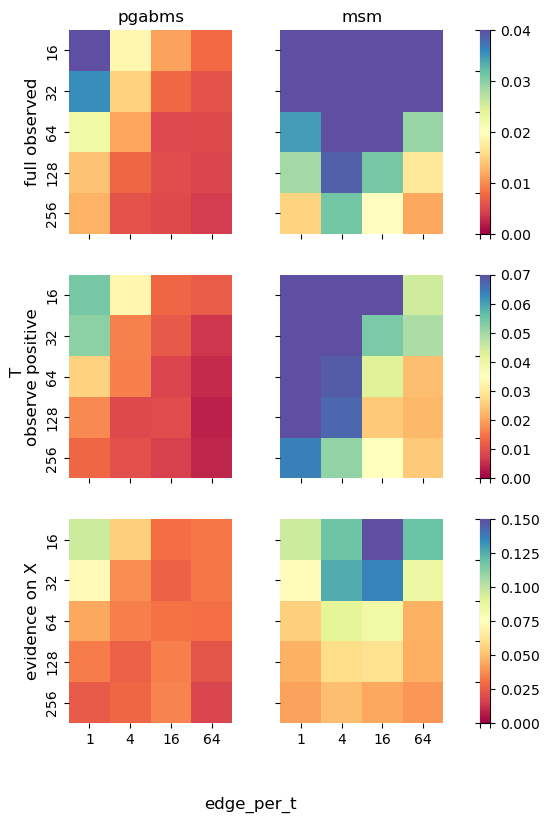

In [19]:
vmin_vmax = [(0, 0.04), (0, 0.07), (0, 0.15)]
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (5, 9), sharex = True, sharey = True)


for i, model in enumerate(["full observed", "observe positive", "evidence on X"]):
    
    for j, method in enumerate(["pgabms", "msm"]):
        
        ax = axes[i,j]
        
        cbar_ax = fig.add_axes([.96, ax.get_position().y0, .02, ax.get_position().height])
        cbar_ax.set_xticklabels([])
        cbar_ax.set_yticklabels([])

        sns.heatmap(data = dict_data[method][i].groupby(["T", "edge_per_t"])["distance_epsilon"].mean().unstack(),
                    ax = ax, cmap = "Spectral", 
                    vmin = vmin_vmax[i][0], vmax = vmin_vmax[i][1], square = True,
                    cbar = j == 1, cbar_ax = None if j == 0 else cbar_ax)#, norm = LogNorm())
        if i == 0:
            ax.set_title(method)
        
        ax.set_ylabel(model if j == 0 else "", rotation = 90, size='large')
        ax.set_xlabel("")
        
fig.supylabel("T")
fig.supxlabel("edge_per_t")
    
    #axes[i,1].collections[0].set_clim(vmin_vmax[i])               # set vmin and vmax



In [20]:
pgabms_simple["distance_epsilon"].mean(), msm_simple["distance_epsilon"].mean()

(0.012329439066782806, 0.0488191523288831)

In [21]:
pgabms_pos["distance_epsilon"].mean(), msm_pos["distance_epsilon"].mean()

(0.01626962397284188, 0.06101320899253593)

In [22]:
pgabms_evidences["distance_epsilon"].mean(), msm_evidences["distance_epsilon"].mean()

(0.03729927132753441, 0.07906681406746253)

## Relative error epsilon

In [23]:
dict_data = {"pgabms": [pgabms_simple, pgabms_pos, pgabms_evidences], 
             "msm": [msm_simple, msm_pos, msm_evidences]}

In [46]:
pd.merge(
    pgabms_simple[["T", "edge_per_t","real_epsilon", "epsilon_estimated", "distance_epsilon", "relative_error_epsilon"]].groupby(["T", "edge_per_t"]).mean(),
    msm_simple[["T", "edge_per_t","real_epsilon", "estimated_epsilon", "distance_epsilon", "relative_error_epsilon"]].groupby(["T", "edge_per_t"]).mean(),
    on = ["T", "edge_per_t"]
)[["distance_epsilon_x", "distance_epsilon_y", "relative_error_epsilon_x", "relative_error_epsilon_y"]]

pgabms_simple.query("(T == 16)&(edge_per_t == 4)")[["real_epsilon", "epsilon_estimated", "distance_epsilon", "relative_error_epsilon"]]

,real_epsilon,epsilon_estimated,distance_epsilon,relative_error_epsilon
5,0.298820,0.295260,0.003559,0.011912
25,0.360918,0.349594,0.011324,0.031377
45,0.251033,0.217962,0.033071,0.131740
65,0.482980,0.497562,0.014582,0.030191
85,0.103273,0.093990,0.009283,0.089884
105,0.407768,0.453818,0.046049,0.112930
125,0.111885,0.075585,0.036300,0.324439
145,0.202754,0.199671,0.003082,0.015203
165,0.492141,0.438469,0.053672,0.109059
185,0.343766,0.339957,0.003808,0.011079


Text(0.5, 0.01, 'edge_per_t')

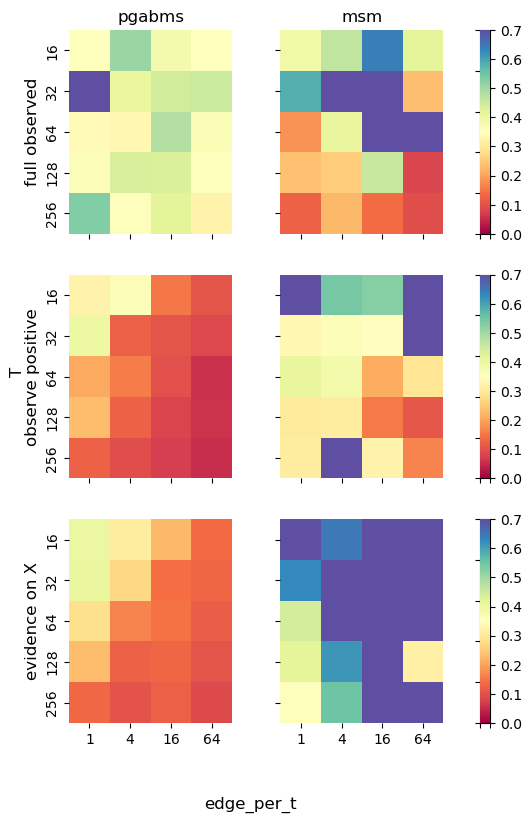

In [26]:
vmin_vmax = [(0, 0.7), (0, 0.7), (0, 0.7)]
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (5, 9), sharex = True, sharey = True)


for i, model in enumerate(["full observed", "observe positive", "evidence on X"]):
    
    for j, method in enumerate(["pgabms", "msm"]):
        
        ax = axes[i,j]
        
        cbar_ax = fig.add_axes([.96, ax.get_position().y0, .02, ax.get_position().height])
        cbar_ax.set_xticklabels([])
        cbar_ax.set_yticklabels([])

        sns.heatmap(data = dict_data[method][i].groupby(["T", "edge_per_t"])["relative_error_epsilon"].mean().unstack(),
                    ax = ax, cmap = "Spectral", 
                    vmin = vmin_vmax[i][0], vmax = vmin_vmax[i][1], square = True,
                    cbar = j == 1, cbar_ax = None if j == 0 else cbar_ax)#, norm = LogNorm())
        if i == 0:
            ax.set_title(method)
        
        ax.set_ylabel(model if j == 0 else "", rotation = 90, size='large')
        ax.set_xlabel("")
        
fig.supylabel("T")
fig.supxlabel("edge_per_t")
    
    #axes[i,1].collections[0].set_clim(vmin_vmax[i])               # set vmin and vmax



In [8]:
pgabms_simple["distance_epsilon"].mean(), msm_simple["distance_epsilon"].mean()

(0.012329439066782806, 0.0488191523288831)

In [9]:
pgabms_pos["distance_epsilon"].mean(), msm_pos["distance_epsilon"].mean()

(0.01626962397284188, 0.06101320899253593)

In [10]:
pgabms_evidences["distance_epsilon"].mean(), msm_evidences["distance_epsilon"].mean()

(0.03729927132753441, 0.07906681406746253)

## Time

In [191]:
dict_data = {"pgabms": [pgabms_simple, pgabms_pos, pgabms_evidences], 
             "msm": [msm_simple, msm_pos, msm_evidences]}



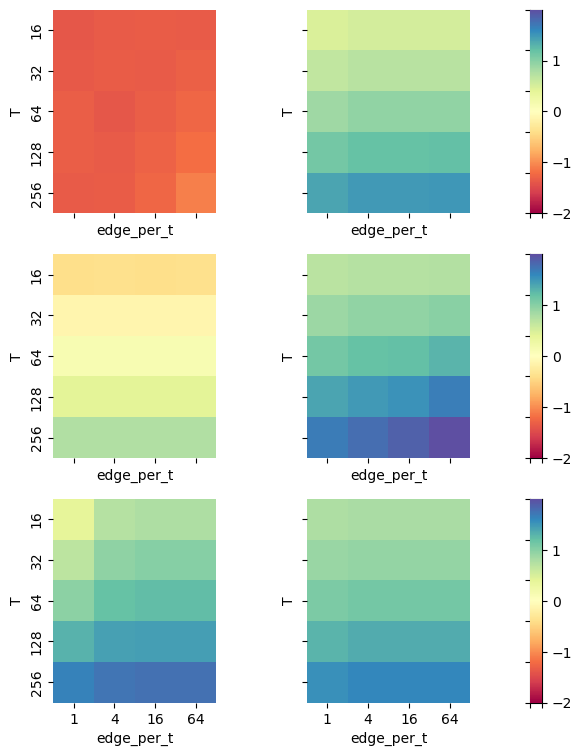

In [192]:
vmin_vmax = [(0.01, 100), (0.01, 100), (0.01, 100)]

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (6, 9), sharex = True, sharey = True)


for i in range(3):

    for j, method in enumerate(["pgabms", "msm"]):
        ax = axes[i,j]
        cbar_ax = fig.add_axes([.96, ax.get_position().y0, .02, ax.get_position().height], )
        cbar_ax.set_xticklabels([])
        cbar_ax.set_yticklabels([])
        
        sns.heatmap(data = np.log10(dict_data[method][i].groupby(["T", "edge_per_t"])["time"].mean().unstack()),
                    ax = ax, cmap = "Spectral", 
                    vmin = np.log10(vmin_vmax[i][0]), vmax = np.log10(vmin_vmax[i][1]), square = True,
                    cbar = j == 1, 
                    cbar_ax = None if j == 0 else cbar_ax,
                    cbar_kws = {'ticks': [i - 2 for i in range(4)]}
                   )#, norm = LogNorm())
        
    
    #axes[i,1].collections[0].set_clim(vmin_vmax[i])               # set vmin and vmax



In [214]:
pgabms_simple["time"].mean(), msm_simple["time"].mean()

(0.049338892102241474, 12.232024705410003)

In [215]:
pgabms_pos["time"].mean(), msm_pos["time"].mean()

(2.172440506517887, 59.141249379018944)

In [217]:
pgabms_evidences["time"].mean(), msm_evidences["time"].mean()

(21.347390064348776, 17.544652213652927)

### Backfire Effect

In [251]:
msm_backfire = pd.read_csv("../data/repeat_msm_bc_backfire_230725.csv")

<AxesSubplot:xlabel='edge_per_t', ylabel='T'>

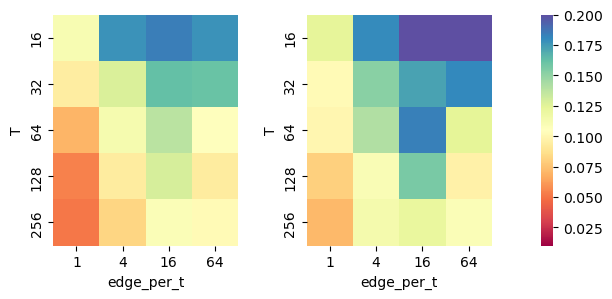

In [252]:
vmin_vmax = (0.01, 0.2)

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (6,3))


cbar_ax = fig.add_axes([.96, axes[1].get_position().y0, .02, axes[1].get_position().height], )
cbar_ax.set_xticklabels([])
cbar_ax.set_yticklabels([])
        
sns.heatmap(data = msm_backfire.groupby(["T", "edge_per_t"])["distance_epsilon_plus"].mean().unstack(),
            ax = axes[0], cmap = "Spectral", 
            vmin = vmin_vmax[0], vmax = vmin_vmax[1], square = True,
            cbar = False, cbar_ax = None if j == 0 else cbar_ax)
        
sns.heatmap(data = msm_backfire.groupby(["T", "edge_per_t"])["distance_epsilon_minus"].mean().unstack(),
            ax = axes[1], cmap = "Spectral", 
            vmin = vmin_vmax[0], vmax = vmin_vmax[1], square = True,
            cbar = True, cbar_ax = None if j == 0 else cbar_ax)
        



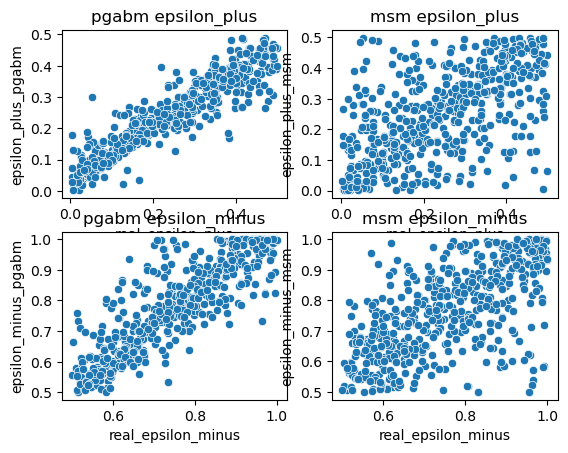

In [199]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)#, sharey = True, sharex = True)

for i,eps in enumerate(["epsilon_plus", "epsilon_minus"]):
    for j, meth in enumerate(["pgabm", "msm"]):
        ax = axes[i,j]
        x,y = f"real_{eps}", f"{eps}_{meth}"
        sns.scatterplot(data = compare_backfire_df.query("(epsilon_plus_pgabm < 0.5)&(epsilon_minus_pgabm > 0.5)"), 
                            x = x, y = y, ax = ax)
        ax.set_title(f"{meth} {eps}")

In [29]:
reload(oe)


<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [16]:
def complete_comparison_simple_BC(N, T, edge_per_t, evidences_per_t = 1, rho = 16,
                                  calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    #epsilon, mu = np.random.random(2) / 2
    mu = 0.1
    epsilon = np.random.random() / 2
    
    X, edges, _ = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    simulator = BC_simulator(X[0], edges, N, mu, epsilon, rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, calibration_batches = calibration_batches, ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, _, (epsilon, mu, rho), **hyperparams_simple_BC)
    
    
    return {"real_epsilon": epsilon, 
            "mu": mu, 
            "rho": rho, 
            "epsilon_msm": calibration_df["epsilon"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches, 
            "abs_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon),
            "rel_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon) / epsilon,
            "ensemble_size": ensemble_size,
            "epsilon_pgabm": pgabm_estimation["epsilon_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm": pgabm_estimation["distance_epsilon"],
            "rel_error_pgabm": pgabm_estimation["distance_epsilon"] / epsilon,
            "num_epochs_pgabm": pgabm_estimation["num_epochs"]
           }


def complete_comparison_BC_observed_positive(N, T, edge_per_t, evidences_per_t = 1, rho = 16, calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    #epsilon, mu = np.random.random(2) / 2
    mu = 0.1
    epsilon = np.random.random() / 2
    X, edges,_ = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    simulator = BC_simulator_positive_observations(X[0], edges, N, mu, epsilon, rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, calibration_batches = calibration_batches, ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, _, (epsilon, mu, rho), **hyperparams_obs_pos_BC)
    
    
    return {"real_epsilon": epsilon, 
            "mu": mu, 
            "rho": rho, 
            "epsilon_msm": calibration_df["epsilon"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches, 
            "abs_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon),
            "rel_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon) / epsilon,
            "ensemble_size": ensemble_size,
            "epsilon_pgabm": pgabm_estimation["epsilon_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm": pgabm_estimation["distance_epsilon"],
            "rel_error_pgabm": pgabm_estimation["distance_epsilon"] / epsilon,
            "num_epochs_pgabm": pgabm_estimation["num_epochs"]
           }


def complete_comparison_BC_with_evidences(N, T, edge_per_t, evidences_per_t, rho = 16, calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    #epsilon, mu = np.random.random(2) / 2
    mu = 0.1
    epsilon = np.random.random() / 2
    
    X, edges, evidences = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))
    simulator = BC_simulator_X_evidences(N, edges, evidences, mu, epsilon, rho = rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, calibration_batches = calibration_batches, ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, evidences, (epsilon, mu, rho), **hyperparams_evidence_BC)
    
    
    return {"real_epsilon": epsilon, 
            "mu": mu, 
            "rho": rho, 
            "epsilon_msm": calibration_df["epsilon"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches, 
            "abs_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon),
            "rel_error_msm": np.abs(calibration_df["epsilon"][0] - epsilon) / epsilon,
            "ensemble_size": ensemble_size,
            "epsilon_pgabm": pgabm_estimation["epsilon_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm": pgabm_estimation["distance_epsilon"],
            "rel_error_pgabm": pgabm_estimation["distance_epsilon"] / epsilon,
            "X0_r2": pgabm_estimation["X0_r2"],
            "X0_mae": pgabm_estimation["X0_mae"],
            "X0_mse": pgabm_estimation["X0_mse"],
            "num_epochs_pgabm": pgabm_estimation["num_epochs"]
           }

def complete_comparison_BC_backfire(N, T, edge_per_t, evidences_per_t, rho = 16, calibration_batches = 400, ensemble_size = 1, seed = None):
    np.random.seed(seed)
    epsilon_plus = np.random.random() / 2
    epsilon_minus = 0.5 + (np.random.random() / 2)
    #mu_plus = mu_minus = np.random.random() / 2
    mu_plus = mu_minus = 0.1
    
    X, edges, evidences = simulate_BC(N, T, edge_per_t, evidences_per_t, 
                                      (epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho), model = "backfire")
    simulator = BC_simulator_X_evidences_backfire(N, edges, evidences, mu_plus, mu_minus, 
                                                  epsilon_plus, epsilon_minus, rho = rho)
    calibration_df, time_calibration = calibrate_params_ABM(simulator, 
                                                            parameters_names = ["epsilon_plus", "epsilon_minus"],
                                                            precisions = [0.0001, 0.0001],
                                                            parameters_bounds = [[0.,.5], [.5,1.]],
                                                            calibration_batches = calibration_batches, 
                                                            ensemble_size = ensemble_size)
    
    pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, evidences, 
                                                        (epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho), 
                                                        **hyperparams_backfire_BC)
    
    return {"real_epsilon_plus": epsilon_plus, 
            "real_epsilon_minus": epsilon_minus,
            "mu_plus": mu_plus, 
            "mu_minus": mu_minus, 
            "rho": rho, 
            "epsilon_plus_msm": calibration_df["epsilon_plus"][0], 
            "epsilon_minus_msm": calibration_df["epsilon_minus"][0], 
            "time_msm": time_calibration,
            "calibration_batches": calibration_batches,
            "abs_error_msm_plus": np.abs(calibration_df["epsilon_plus"][0] - epsilon_plus),
            "abs_error_msm_minus": np.abs(calibration_df["epsilon_minus"][0] - epsilon_minus),
            "rel_error_msm_plus": np.abs(calibration_df["epsilon_plus"][0] - epsilon_plus) / epsilon_plus,
            "rel_error_msm_minus": np.abs(calibration_df["epsilon_minus"][0] - epsilon_minus) / epsilon_minus,
            "ensemble_size": ensemble_size,
            "epsilon_plus_pgabm": pgabm_estimation["epsilon_plus_estimated"],
            "epsilon_minus_pgabm": pgabm_estimation["epsilon_minus_estimated"],
            "time_pgabm": pgabm_estimation["time"],
            "abs_error_pgabm_plus": pgabm_estimation["distance_epsilon_plus"],
            "abs_error_pgabm_minus": pgabm_estimation["distance_epsilon_minus"],
            "rel_error_pgabm_plus": pgabm_estimation["distance_epsilon_plus"] / epsilon_plus,
            "rel_error_pgabm_minus": pgabm_estimation["distance_epsilon_minus"] / epsilon_minus,
            "X0_r2": pgabm_estimation["X0_r2"],
            "X0_mae": pgabm_estimation["X0_mae"],
            "X0_mse": pgabm_estimation["X0_mse"],
            "num_epochs_pgabm": pgabm_estimation["num_epochs"]
           }

In [11]:
N, T, edge_per_t, evidences_per_t = 100, 64, 8, 16

rho = 16

In [7]:
del hyperparams_simple_BC["min_delta"]
del hyperparams_simple_BC["min_epochs"]
del hyperparams_simple_BC["patience"]
del hyperparams_obs_pos_BC["min_delta"]
del hyperparams_obs_pos_BC["min_epochs"]
del hyperparams_obs_pos_BC["patience"]
del hyperparams_evidence_BC["min_delta"]
del hyperparams_evidence_BC["min_epochs"]
del hyperparams_evidence_BC["patience"]

In [5]:
hyperparams_simple_BC["early_stopping_kw"] = {"patience": 20, "min_delta": 1e-5,
                                              "min_epochs": 20, "long_run_delta": 1e-3, 
                                              "long_run_diff":20, "long_run_patience": 10}
hyperparams_obs_pos_BC["early_stopping_kw"] = {"patience": 20, "min_delta": 1e-5,
                                              "min_epochs": 20, "long_run_delta": 1e-3, 
                                              "long_run_diff":20, "long_run_patience": 10}
hyperparams_evidence_BC["early_stopping_kw"] = {"patience": 20, "min_delta": 1e-5,
                                              "min_epochs": 20, "long_run_delta": 1e-3, 
                                              "long_run_diff":20, "long_run_patience": 10}

In [18]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

### Simple

In [19]:
comparison = complete_comparison_simple_BC(N, T, edge_per_t, evidences_per_t, 
                                               calibration_batches = 100, ensemble_size = 1, seed = None)


In [21]:
comparison

{'real_epsilon': 0.1897473259891424,
 'mu': 0.1,
 'rho': 16,
 'epsilon_msm': 0.20020000000000002,
 'time_msm': 2.132398843765259,
 'calibration_batches': 100,
 'abs_error_msm': 0.010452674010857615,
 'rel_error_msm': 0.05508733235827382,
 'ensemble_size': 1,
 'epsilon_pgabm': 0.17290723524375406,
 'time_pgabm': 0.011779308319091797,
 'abs_error_pgabm': 0.016840090745388336,
 'rel_error_pgabm': 0.08875008202409107,
 'num_epochs_pgabm': 32}

### Observe positive

In [22]:
comparison = complete_comparison_BC_observed_positive(N, T, edge_per_t, evidences_per_t, 
                                                      calibration_batches = 100, ensemble_size = 1, seed = None)


In [23]:
comparison

{'real_epsilon': 0.20358051378416803,
 'mu': 0.1,
 'rho': 16,
 'epsilon_msm': 0.016110000000000003,
 'time_msm': 2.639906883239746,
 'calibration_batches': 100,
 'abs_error_msm': 0.187470513784168,
 'rel_error_msm': 0.9208666895443661,
 'ensemble_size': 1,
 'epsilon_pgabm': 0.17581441164451272,
 'time_pgabm': 0.24967193603515625,
 'abs_error_pgabm': 0.027766102139655302,
 'rel_error_pgabm': 0.1363888007920658,
 'num_epochs_pgabm': 45}

### Evidences 

In [24]:
comparison = complete_comparison_BC_with_evidences(N, T, edge_per_t, evidences_per_t, 
                                                   calibration_batches = 100, ensemble_size = 1, seed = None)


In [25]:
comparison

{'real_epsilon': 0.0242069783459124,
 'mu': 0.1,
 'rho': 16,
 'epsilon_msm': 0.17804,
 'time_msm': 3.0836358070373535,
 'calibration_batches': 100,
 'abs_error_msm': 0.1538330216540876,
 'rel_error_msm': 6.354903922986485,
 'ensemble_size': 1,
 'epsilon_pgabm': 0.038987827329532605,
 'time_pgabm': 2.788625717163086,
 'abs_error_pgabm': 0.014780848983620205,
 'rel_error_pgabm': 0.6106028093389072,
 'X0_r2': 0.8373653888702393,
 'X0_mae': 0.09338035434484482,
 'X0_mse': 0.01642603799700737,
 'num_epochs_pgabm': 124}

In [137]:
comparison["time_msm"]

3.047316551208496

In [24]:
reload(oe)

<module 'opinion_dynamics_models_estimation' from '/home/jacopo.lenti/Projects/learning-od-step-by-step/src/opinion_dynamics_models_estimation.py'>

In [112]:
mu = 0.1
epsilon = np.random.random() / 2


X, edges, evidences = simulate_BC(N, T, edge_per_t, evidences_per_t, (epsilon, mu, rho))

pgabm_estimation = oe.estimation_BC_model_from_data(X, edges, evidences, (epsilon, mu, rho),
                                                    model_name = "BC_with_evidence",
                                                    summarized = False,
                                                    optimizer_name = "RMSprop", lr = 0.05,
                                                    num_epochs = 400, X0_lr_scale = 10,
                                                    early_stopping_kw = {"patience": 20, "min_delta": 1e-5,
                                                                         "min_epochs": 20, "long_run_delta": 1e-7, 
                                                                         "long_run_diff":20, "long_run_patience": 10}
                                                    
                                                   )
    

In [119]:
l = np.array(pgabm_estimation["epsilon"])
condition = np.where((np.abs(l[20:] - l[:-20]) < 1e-3).cumsum() > 10)
vert_ = 0
if len(condition[0]) > 0:
    vert_ = np.where((np.abs(l[20:] - l[:-20]) < 1e-3).cumsum() > 10)[0][0] 

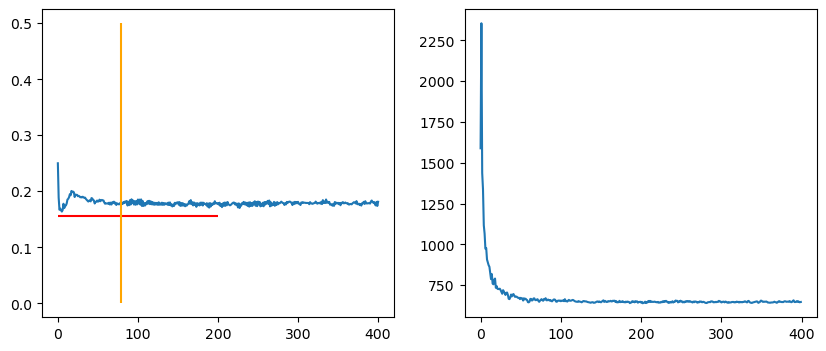

In [120]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].plot(pgabm_estimation["epsilon"])
axes[0].hlines(y = epsilon, xmin = 0, xmax = 200, colors = "red")
axes[0].vlines(x = vert_, ymin = 0., ymax = 0.5, colors = "orange")
axes[1].plot(pgabm_estimation["loss"])

In [87]:
min_delta1 = 1e-03
min_delta2 = 1e-04
patience = 50
min_epoch = 20

estimates = np.array(pgabm_estimation["epsilon"])
l_diff = np.abs(np.diff((estimates[1:] + estimates[:-1]) / 2)) #np.abs(np.diff(pgabm_estimation["epsilon"]))
counter1, counter2 = 0,0
consecutive_counter1,consecutive_counter2 = [],[] 

for epoch in range(len(l_diff)):
    if (epoch > min_epoch)&(l_diff[epoch] < min_delta1):
        counter1 += 1
    else: 
        counter1 = 0
    if (epoch > min_epoch)&(l_diff[epoch] < min_delta2):
        counter2 += 1
    else: 
        counter2 = 0
    consecutive_counter1.append((epoch, counter1))
    consecutive_counter2.append((epoch,counter2))

In [15]:
consecutive_counter1

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 0),
 (13, 0),
 (14, 0),
 (15, 0),
 (16, 0),
 (17, 0),
 (18, 0),
 (19, 0),
 (20, 0),
 (21, 1),
 (22, 2),
 (23, 3),
 (24, 4),
 (25, 5),
 (26, 6),
 (27, 7),
 (28, 8),
 (29, 9),
 (30, 10),
 (31, 11),
 (32, 12),
 (33, 13),
 (34, 14),
 (35, 15),
 (36, 16),
 (37, 17),
 (38, 18),
 (39, 19),
 (40, 20),
 (41, 21),
 (42, 22),
 (43, 23),
 (44, 24),
 (45, 25),
 (46, 26),
 (47, 27),
 (48, 28),
 (49, 29),
 (50, 30),
 (51, 31),
 (52, 32),
 (53, 33),
 (54, 34),
 (55, 35),
 (56, 36),
 (57, 37),
 (58, 38),
 (59, 39),
 (60, 40),
 (61, 41),
 (62, 42),
 (63, 43),
 (64, 44),
 (65, 45),
 (66, 46),
 (67, 47),
 (68, 48),
 (69, 49)]

In [169]:
estimates = np.array(pgabm_estimation["epsilon"])

In [173]:
np.diff((estimates[1:] + estimates[:-1]) / 2)

array([ 5.77558587e-02,  3.69116157e-02,  1.43129312e-02,  8.55904957e-03,
        9.37294515e-03,  6.41370542e-03,  6.84639180e-04,  1.28137971e-03,
        2.28411024e-03,  1.54563340e-04, -6.63775278e-04, -2.97407724e-03,
       -1.47630259e-03, -1.50907683e-03, -1.50540382e-03, -4.26476426e-04,
       -1.06018595e-03, -1.68446728e-03, -1.45957991e-03, -2.11175739e-03,
       -1.21026811e-03, -2.79158973e-03, -2.00078500e-03, -1.03704674e-04,
       -9.23456765e-04, -2.14922537e-03, -1.83533861e-03, -1.49251574e-03,
       -1.27716750e-03, -2.25672148e-03, -1.85671990e-03, -4.52355880e-04,
       -8.55924063e-04, -2.68426849e-03, -1.28896509e-03, -3.14641525e-04,
       -8.24796192e-04, -1.19461588e-03, -9.30249563e-04, -9.81387775e-05,
       -6.34626751e-04, -1.93192038e-03, -9.02643897e-04,  2.53913604e-04,
       -4.16815021e-04, -1.00518656e-03, -5.74705402e-04, -2.41908486e-04,
       -4.32035049e-04, -1.20209699e-03, -5.18341472e-04,  4.39624121e-04,
       -5.16895291e-04, -